In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import requests


def load_json_url(url):
    response = requests.get(url)
    raw = response.json()
    data = [v for v in raw.values() if isinstance(v, dict)]
    df = pd.DataFrame(data)
    df["waktu"] = df["waktu"].str.replace(".", ":", regex=False)

    # Parse datetime
    df["timestamp"] = pd.to_datetime(df["waktu"], format="%d/%m/%Y, %H:%M:%S")
    df.index = df.set_index(df["timestamp"])

    # Sort
    df = df.sort_values("timestamp").reset_index(drop=True)

    return df

# Firebase Realtime Database perlu akhiran .json
url = "https://iotexperiment-9b165-default-rtdb.asia-southeast1.firebasedatabase.app/sensor/temperature.json"

df = load_json_url(url)
print(df)

       ldr  pir                 waktu           timestamp
0      164  0.0   6/12/2025, 00:15:27 2025-12-06 00:15:27
1      164  0.0   6/12/2025, 00:15:27 2025-12-06 00:15:27
2      630  1.0   6/12/2025, 00:15:29 2025-12-06 00:15:29
3      630  1.0   6/12/2025, 00:15:29 2025-12-06 00:15:29
4      553  0.0   6/12/2025, 00:15:31 2025-12-06 00:15:31
...    ...  ...                   ...                 ...
15632  616  1.0  17/12/2025, 00:49:33 2025-12-17 00:49:33
15633  616  0.0  17/12/2025, 00:49:35 2025-12-17 00:49:35
15634  621  0.0  17/12/2025, 00:49:37 2025-12-17 00:49:37
15635  616  0.0  17/12/2025, 00:49:39 2025-12-17 00:49:39
15636  616  0.0  17/12/2025, 00:49:41 2025-12-17 00:49:41

[15637 rows x 4 columns]


In [3]:
def remove_outlier_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df[(df[column] >= lower_bound) & 
                  (df[column] <= upper_bound)]
    return df_clean

# contoh penggunaan
df_clean = remove_outlier_iqr(df, 'ldr')


In [4]:
df_clean['ldr_smooth'] = df['ldr'].rolling(30).mean()
df_clean['ldr_smooth'].fillna(method='bfill', inplace=True)
print(df_clean)

       ldr  pir                 waktu           timestamp  ldr_smooth
2      630  1.0   6/12/2025, 00:15:29 2025-12-06 00:15:29  564.800000
3      630  1.0   6/12/2025, 00:15:29 2025-12-06 00:15:29  564.800000
4      553  0.0   6/12/2025, 00:15:31 2025-12-06 00:15:31  564.800000
5      553  0.0   6/12/2025, 00:15:31 2025-12-06 00:15:31  564.800000
6      546  0.0   6/12/2025, 00:15:34 2025-12-06 00:15:34  564.800000
...    ...  ...                   ...                 ...         ...
15632  616  1.0  17/12/2025, 00:49:33 2025-12-17 00:49:33  617.033333
15633  616  0.0  17/12/2025, 00:49:35 2025-12-17 00:49:35  616.933333
15634  621  0.0  17/12/2025, 00:49:37 2025-12-17 00:49:37  617.000000
15635  616  0.0  17/12/2025, 00:49:39 2025-12-17 00:49:39  616.900000
15636  616  0.0  17/12/2025, 00:49:41 2025-12-17 00:49:41  616.800000

[12549 rows x 5 columns]


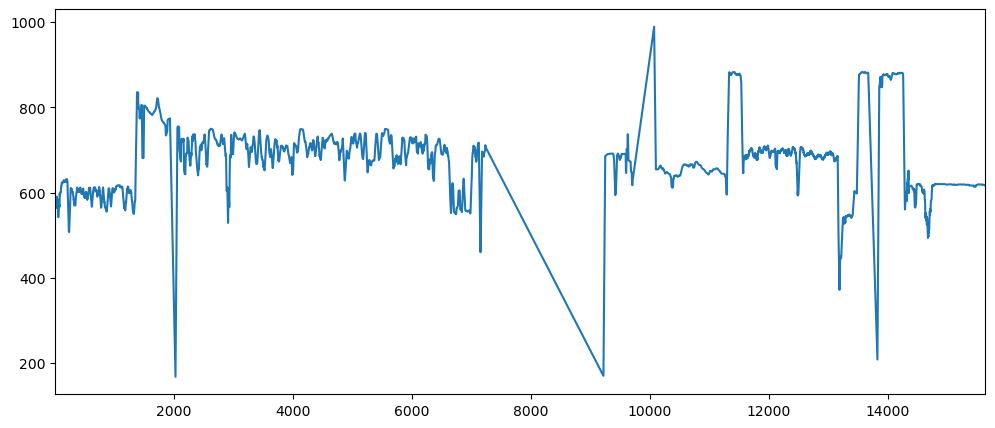

In [5]:
ax = df_clean['ldr_smooth'].plot(figsize=(12,5))
ax.autoscale(axis='x',tight=True)

c:\Users\ASUS\anaconda3\envs\Jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\Jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


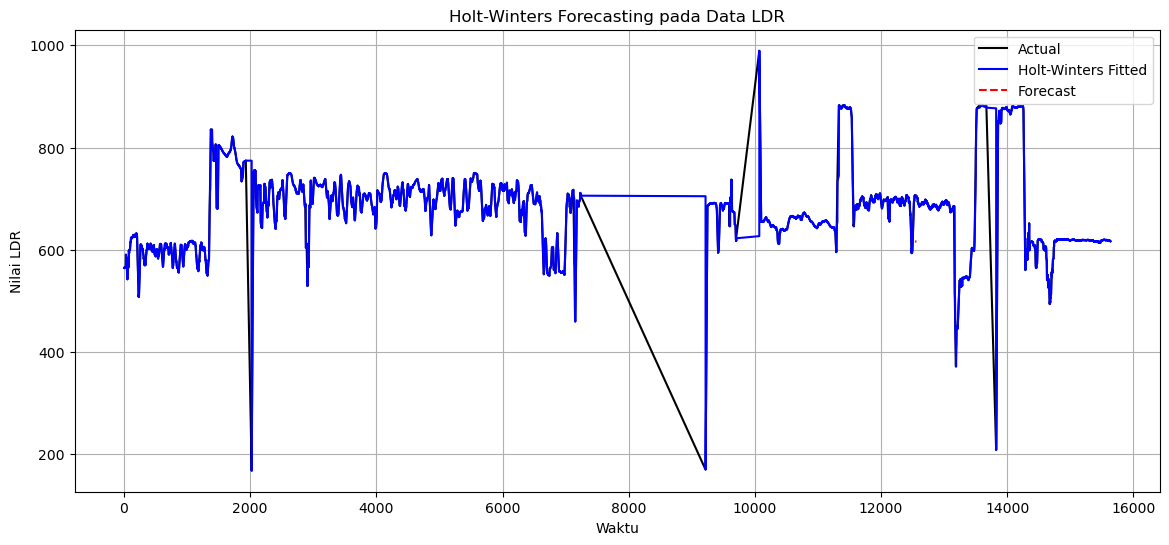

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# MODEL HOLT-WINTERS
hw_model = ExponentialSmoothing(
    df_clean['ldr_smooth'],
    trend='add',
    seasonal='add',
    seasonal_periods=6
).fit(optimized=True)

# FITTED VALUES
df_clean['HW_fitted'] = hw_model.fittedvalues

# FORECAST (misalnya 3 jam ke depan)
forecast_steps = 6
hw_forecast = hw_model.forecast(forecast_steps)



plt.figure(figsize=(14,6))

# Data aktual
plt.plot(df_clean.index, df_clean['ldr_smooth'], label='Actual', color='black')

# Fitted (in-sample prediction)
plt.plot(df_clean.index, df_clean['HW_fitted'], 
         label='Holt-Winters Fitted', color='blue')

# Forecast (out-of-sample)
plt.plot(hw_forecast.index, hw_forecast, 
         label='Forecast', color='red', linestyle='--')

plt.title('Holt-Winters Forecasting pada Data LDR')
plt.xlabel('Waktu')
plt.ylabel('Nilai LDR')
plt.legend()
plt.grid(True)
plt.show()



In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(
    df_clean['ldr_smooth'].iloc[-len(df_clean['HW_fitted']):],
    df_clean['HW_fitted']
))

print("RMSE Holt-Winters:", rmse)
mean_data = df_clean['ldr_smooth'].mean()

relative_rmse = rmse / mean_data
print(relative_rmse)

RMSE Holt-Winters: 10.702179959257036
0.015863190013527664


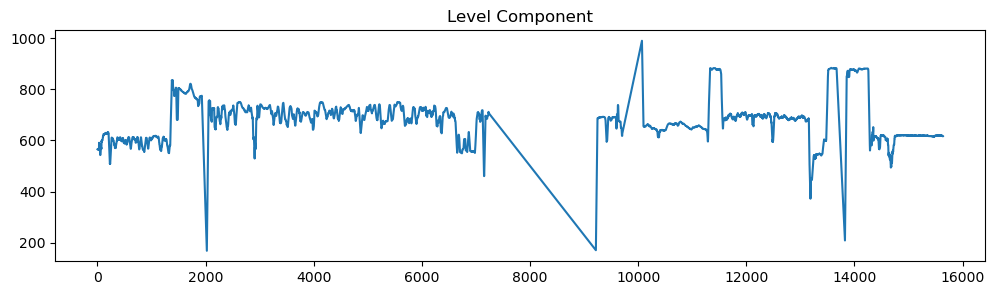

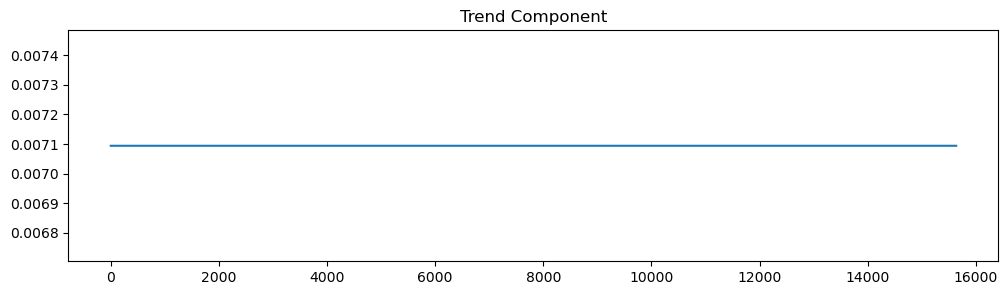

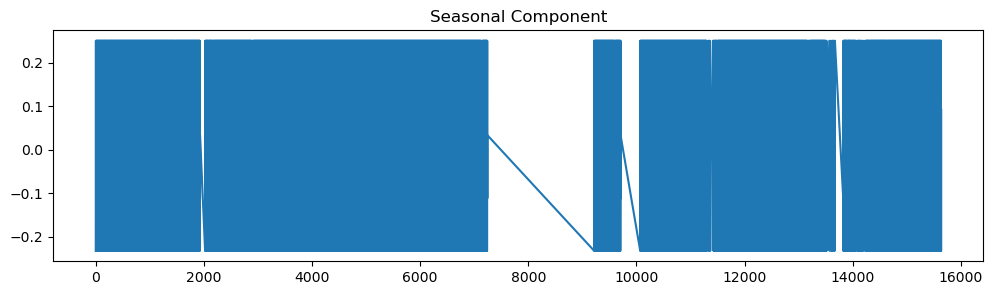

In [8]:
hw_model.level.plot(title="Level Component", figsize=(12,3))
plt.show()

hw_model.trend.plot(title="Trend Component", figsize=(12,3))
plt.show()

hw_model.season.plot(title="Seasonal Component", figsize=(12,3))
plt.show()